# Simulating a Card Game: 6 nimmt

## Game Rules

1. Game Setup

   - Players: Each game can have between 2 to 10 players.
   - Deck: Consists of 104 cards numbered 1 to 104.
   - Initial Setup: Each player is dealt 10 cards, and four cards are placed face-up to start four rows.

2. Game Flow

   - Round: Players simultaneously select a card to play.
   - Card Placement: Cards are placed in rows according to game rules.
   - Penalties: Players collect cards if they have to place the sixth card in a row.

3. Ending the Game

   - The game ends after 10 rounds. The player with the fewest penalty points wins.

## Simulation Framework

In [78]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

debug = True

# Define Player class
class Player:
    def __init__(self, strategy, player_id):
        self.strategy = strategy
        self.hand = []
        self.penalty_points = 0        
        self.player_id = player_id

    def choose_card(self, game_state):
        return self.strategy(self, game_state)

# Define Game class
class Game:
    def __init__(self, strategies):
        self.players = [Player(strategy, i) for i, strategy in enumerate(strategies)]
        self.deck = list(range(1, 105))
        self.rows = []

    def setup(self):
        np.random.shuffle(self.deck)
        for player in self.players:
            player.hand = sorted([self.deck.pop() for _ in range(10)])
        self.rows = [[self.deck.pop()] for _ in range(4)]  # Initialize four rows with one card each
        
    def get_bullheads(self, card):
        if card % 55 == 0:
            return 7
        elif card % 11 == 0:
            return 5
        elif card % 10 == 0:
            return 3
        elif card % 5 == 0:
            return 2
        else:
            return 1

    def play_round(self):
        # Each player chooses a card to play
        chosen_cards = [(player.choose_card(self.rows), player) for player in self.players]
        chosen_cards.sort()  # Sort cards to determine play order
        
        if (debug): 
            print("Chosen cards:", [(card, player.player_id) for card, player in chosen_cards])

        for card, player in chosen_cards:
            row_choice = None
            min_difference = float('inf')
            
            # Find the best row to place the card
            for row in self.rows:
                if row[-1] < card:
                    difference = card - row[-1]
                    if difference < min_difference:
                        min_difference = difference
                        row_choice = row
            
            if row_choice is None:
                # Card can't be placed in any row, because it is smaller than the last card in any row, so the player must take one row
                if (debug):
                    print("Card can't be placed in any row")
                # Player takes the row with the fewest penalty points
                row_choice = min(self.rows, key=lambda r: sum(self.get_bullheads(c) for c in r))
            
                penalty_points = sum(self.get_bullheads(c) for c in row_choice)
                if (debug):
                    print(f"Player{player.player_id} chooses to take row {row_choice} and incurs {penalty_points} penalty points")
                player.penalty_points += penalty_points
                self.rows.remove(row_choice)
                self.rows.append([card]) # The card starts a new row
            else:
                if (debug):
                    print("Card is is the 6th card in a row")
                row_choice.append(card)
                if len(row_choice) > 5:
                    # Player takes the five cards and incurs penalty points
                    penalty_points = sum(self.get_bullheads(c) for c in row_choice[:-1])
                    if (debug):
                        print(f"Player{player.player_id} must take row {row_choice[:-1]} and incurs {penalty_points} penalty points")
                    player.penalty_points += penalty_points
                    row_choice[:] = [row_choice[-1]]  # Start new row with the last card
                    
            if (debug):
                # Print the state after each card placement
                print(f"After Player{player.player_id} places {card}:")
                for row in self.rows:
                    print(row)



    def play_game(self):
        self.setup()
        
        if (debug):
            print("Initial hands:")
            for player in self.players:
                print(f"Player {player.player_id}: {player.hand}")
            print("Initial rows:", self.rows)
            
        for round_number in range(10):
            if (debug):
                print(f"--- Round {round_number + 1} ---")
            self.play_round()
            
        final_scores = [player.penalty_points for player in self.players]
        if (debug):
            print("Final scores:", final_scores)
        return final_scores


## Strategy Implementation

- Random: Play a random card.
- Lowest First: Play the lowest available card.
- Highest First: Play the highest available card.
- Midrange: Play a card that minimizes the difference with the last card in a row.

In [79]:
# Strategy 1: Random
def random_strategy(player, game_state):
    return player.hand.pop(np.random.randint(len(player.hand)))

# Strategy 2: Lowest First
def lowest_first_strategy(player, game_state):
    return player.hand.pop(0)

# Strategy 3: Highest First
def highest_first_strategy(player, game_state):
    return player.hand.pop(-1)

# Strategy 4: Midrange
def midrange_strategy(player, game_state):
    mid_card = min(player.hand, key=lambda x: abs(x - np.mean([row[-1] for row in game_state])))
    player.hand.remove(mid_card)
    return mid_card

# Strategy 5: Avoid Penalty
def avoid_penalty_strategy(player, game_state):
    # Implement a more sophisticated strategy to avoid penalties
    pass


## Executing Simulation

In [80]:
# Playing a single game for debugging purposes
game = Game([random_strategy, lowest_first_strategy, highest_first_strategy, midrange_strategy])
result = game.play_game()
print(result)

Initial hands:
Player 0: [17, 25, 34, 43, 61, 63, 66, 84, 86, 92]
Player 1: [6, 15, 26, 27, 29, 47, 62, 65, 73, 102]
Player 2: [8, 10, 20, 49, 51, 53, 70, 90, 95, 97]
Player 3: [5, 24, 28, 35, 37, 44, 81, 83, 88, 104]
Initial rows: [[22], [68], [85], [59]]
--- Round 1 ---
Chosen cards: [(6, 1), (34, 0), (44, 3), (97, 2)]
Card can't be placed in any row
Player1 chooses to take row [68] and incurs 1 penalty points
After Player1 places 6:
[22]
[85]
[59]
[6]
Card is is the 6th card in a row
After Player0 places 34:
[22, 34]
[85]
[59]
[6]
Card is is the 6th card in a row
After Player3 places 44:
[22, 34, 44]
[85]
[59]
[6]
Card is is the 6th card in a row
After Player2 places 97:
[22, 34, 44]
[85, 97]
[59]
[6]
--- Round 2 ---
Chosen cards: [(15, 1), (17, 0), (37, 3), (95, 2)]
Card is is the 6th card in a row
After Player1 places 15:
[22, 34, 44]
[85, 97]
[59]
[6, 15]
Card is is the 6th card in a row
After Player0 places 17:
[22, 34, 44]
[85, 97]
[59]
[6, 15, 17]
Card is is the 6th card in a 

In [81]:
debug = False

def simulate_games(num_games, strategies):
    results = []
    for _ in range(num_games):
        game = Game(strategies)
        results.append(game.play_game())
    return np.array(results)

# Example strategies: [random_strategy, lowest_first_strategy, highest_first_strategy, midrange_strategy]
results = simulate_games(1000, [random_strategy, lowest_first_strategy, highest_first_strategy, midrange_strategy])
results[:10]

array([[ 3, 26, 26,  0],
       [ 1, 18, 11,  9],
       [ 4, 30, 14,  7],
       [11, 20,  5, 13],
       [19,  3, 14, 10],
       [10, 10,  3, 17],
       [ 9, 14,  7, 11],
       [42, 13,  0,  8],
       [ 8,  4,  0, 22],
       [14, 22, 17,  5]])

## Data Analysis and Visualization

### Metrics

- Average Penalty Points: Measure the effectiveness of each strategy.
- Win Rate: Calculate how often each strategy wins.
- Effect of Number of Players: Compare strategy performance across different numbers of players.
- Influence of Opponents' Strategies: Analyze how the mix of opponents' strategies affects a given strategy.

### Visualization

- Use plots to visualize performance metrics.
- Create heatmaps or other visual aids to show strategy effectiveness in different environments.

### Optimization and Further Exploration

- Parameter Tuning: Optimize strategies for better performance.
- Hybrid Strategies: Combine different strategies for improved results.
- Machine Learning: Explore using machine learning to develop adaptive strategies.

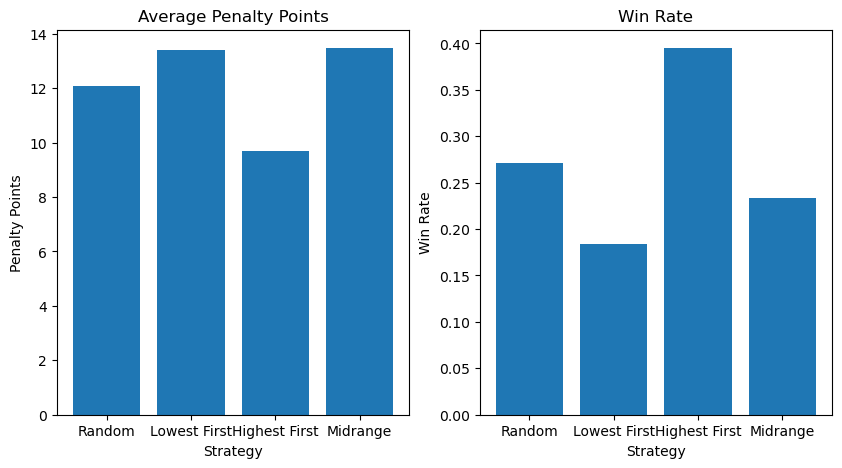

In [82]:
def analyze_results(results):
    avg_penalties = np.mean(results, axis=0)
    win_rates = np.sum(results == np.min(results, axis=1, keepdims=True), axis=0) / len(results)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(avg_penalties)), avg_penalties)
    plt.xticks(range(len(avg_penalties)), ['Random', 'Lowest First', 'Highest First', 'Midrange'])
    plt.title('Average Penalty Points')
    plt.xlabel('Strategy')
    plt.ylabel('Penalty Points')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(win_rates)), win_rates)
    plt.xticks(range(len(win_rates)), ['Random', 'Lowest First', 'Highest First', 'Midrange'])
    plt.title('Win Rate')
    plt.xlabel('Strategy')
    plt.ylabel('Win Rate')

    plt.show()

analyze_results(results)